
神经网络
===============

神经网络可以使用 ``torch.nn`` 包构建.

``autograd`` 实现了反向传播功能, 但是直接用来写深度学习的代码在很多情况下还是稍显复杂, 
``torch.nn`` 是专门为神经网络设计的模块化接口. ``nn`` 构建于 ``Autograd`` 之上, 可用来定义和运行神经网络.
``nn.Module`` 是 ``nn`` 中最重要的类, 可把它看成是一个网络的封装, 包含网络各层定义以及 ``forward`` 方法, 调用 ``forward(input)`` 方法, 可返回前向传播的结果.

例如, 看看这个分类数字图像的网络:

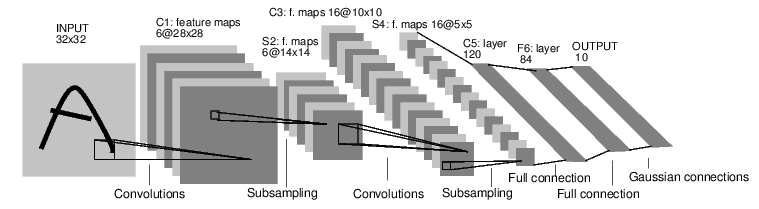

这是一个基础的前向传播(feed-forward)网络: 接收输入, 经过层层传递运算, 得到输出.

一个典型的神经网络训练过程如下:

- 定义具有一些可学习参数(或权重)的神经网络
- 迭代输入数据集
- 通过网络处理输入
- 计算损失(输出的预测值与实际值之间的距离)
- 将梯度传播回网络
- 更新网络的权重, 通常使用一个简单的更新规则:
  ``weight = weight - learning_rate * gradient``

定义网络
------------------

让我们来定义一个网络:



In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 卷积层 '1'表示输入图片为单通道, '6'表示输出通道数, '5'表示卷积核为5*5
        # 核心
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 仿射层/全连接层: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #在由多个输入平面组成的输入信号上应用2D最大池化.
        # (2, 2) 代表的是池化操作的步幅
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 如果大小是正方形, 则只能指定一个数字
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 除批量维度外的所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


你只要在 ``nn.Module`` 的子类中定义了 ``forward`` 函数, ``backward`` 函数就会自动被实现(利用 ``autograd`` ).
在 ``forward`` 函数中可使用任何 Tensor 支持的操作.


 网络的可学习参数通过 ``net.parameters()`` 返回, ``net.named_parameters`` 可同时返回学习的参数以及名称.



In [14]:
params = list(net.parameters())
print(net.parameters())
print(len(params))
print(params[0].size())  # conv1的weight
print(params[1].size())
print(params[2].size())
print(params[3].size())
print(params[4].size())
print(params[5].size())
print(params[6].size())
print(params[7].size())
print(params[8].size())
print(params[9].size())

<generator object parameters at 0x7f6d2b38adc0>
10
torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


向前的输入是一个 ``autograd.Variable``, 输出也是如此.
注意: 这个网络(LeNet)的预期输入大小是 32x32, 使用这个网上 MNIST 数据集, 请将数据集中的图像调整为 32x32.



In [15]:
input = Variable(torch.randn(1, 1, 32, 32))
out = net(input)
print(out)

Variable containing:
 0.0252  0.0592  0.0140  0.0399  0.0894  0.0555  0.0416  0.1241  0.0185  0.0946
[torch.FloatTensor of size 1x10]



将网络中所有参数的梯度清零.



In [16]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>
    
``torch.nn`` 只支持小批量(mini-batches), 不支持一次输入一个样本, 即一次必须是一个 batch.

   例如, ``nn.Conv2d`` 的输入必须是 4 维的, 形如 ``nSamples x nChannels x Height x Width``.

   如果你只想输入一个样本, 需要使用 ``input.unsqueeze(0)`` 将 batch_size 设置为 1.</p></div>

在继续之前, 让我们回顾一下迄今为止所有见过的类.

**概括:**
  -  ``torch.Tensor`` - 一个 *多维数组*.
  -  ``autograd.Variable`` - *包装张量并记录应用于其上的历史操作*.
     具有和 ``Tensor`` 相同的 API ,还有一些补充, 如 ``backward()``.
     另外 *拥有张量的梯度*.
  -  ``nn.Module`` - 神经网络模块. *方便的方式封装参数*,
     帮助将其移动到GPU, 导出, 加载等. 
  -  ``nn.Parameter`` - 一种变量, 当被指定为 ``Model`` 的属性时, 它会自动注册为一个参数.
  -  ``autograd.Function`` - 实现 *autograd 操作的向前和向后定义* .
     每个 ``Variable`` 操作, 至少创建一个 ``Function`` 节点,
     连接到创建 ``Variable`` 的函数, 并 *编码它的历史*.

**在这一点上, 我们涵盖:**
  -  定义一个神经网络
  -  处理输入并反向传播

**还剩下:**
  -  计算损失函数
  -  更新网络的权重

损失函数
-------------
损失函数采用 (output,target) 输入对, 并计算预测输出结果与实际目标的距离. 

在 ``nn`` 包下有几种不同的 `损失函数 <http://pytorch.org/docs/nn.html#loss-functions>`_ .
一个简单的损失函数是: ``nn.MSELoss`` 计算输出和目标之间的均方误差

例如:



In [17]:
output = net(input)
target = Variable(torch.arange(1, 11))  # 一个虚拟的目标
criterion = nn.MSELoss()
print(criterion)
loss = criterion(output, target)
print(loss)

MSELoss(
)
Variable containing:
 37.7998
[torch.FloatTensor of size 1]



现在, 如果你沿着 ``loss`` 反向传播的方向使用 ``.grad_fn`` 属性, 你将会看到一个如下所示的计算图:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

所以, 当我们调用 ``loss.backward()``, 整个图与损失是有区别的,
图中的所有变量都将用 ``.grad`` 梯度累加它们的变量.

为了说明, 让我们向后走几步:



In [18]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

反向传播
--------
为了反向传播误差, 我们所要做的就是 ``loss.backward()``.
你需要清除现有的梯度, 否则梯度会累加之前的梯度.


现在我们使用 ``loss.backward()``, 看看反向传播之前和之后 ``conv1`` 的梯度.



In [19]:
net.zero_grad()     # 把之前的梯度清零

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
Variable containing:
 0
 0
 0
 0
 0
 0
[torch.FloatTensor of size 6]

conv1.bias.grad after backward
Variable containing:
1.00000e-02 *
 -5.4184
  3.2361
  2.7409
 -4.9940
  2.0255
  3.9573
[torch.FloatTensor of size 6]



现在, 我们已经看到了如何使用损失函数.

**稍后阅读:**

  神经网络包包含各种模块和损失函数, 形成深度神经网络的构建模块. 完整的文件列表 `在这里 <http://pytorch.org/docs/nn>`_

**接下来学习的唯一东西是:**

  - 更新网络的权重

更新权重
------------------
实践中使用的最简单的更新规则是随机梯度下降( SGD ):

     
`    weight = weight - learning_rate * gradient`

我们可以使用简单的 python 代码来实现这个:

``
    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)
``


然而, 当你使用神经网络时, 你需要使用各种不同的更新规则, 比如 SGD, Nesterov-SGD, Adam, RMSProp等.
为了实现这个功能, 我们建立了一个包: ``torch.optim`` 实现所有这些方法.
使用它非常的简单:



In [22]:
import torch.optim as optim

# 新建一个优化器, 指定要调整的参数和学习率
optimizer = optim.SGD(net.parameters(), lr = 0.01)
print(optimizer)

# 在训练过程中:
optimizer.zero_grad()   # 首先梯度清零(与 net.zero_grad() 效果一样)
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # 更新参数



观察如何使用手动设置梯度清零 `optimizer.zero_grad()` . 需要手动清零的原因在 `Backprop`_ 中已经说明了(梯度会累加之前的梯度).

